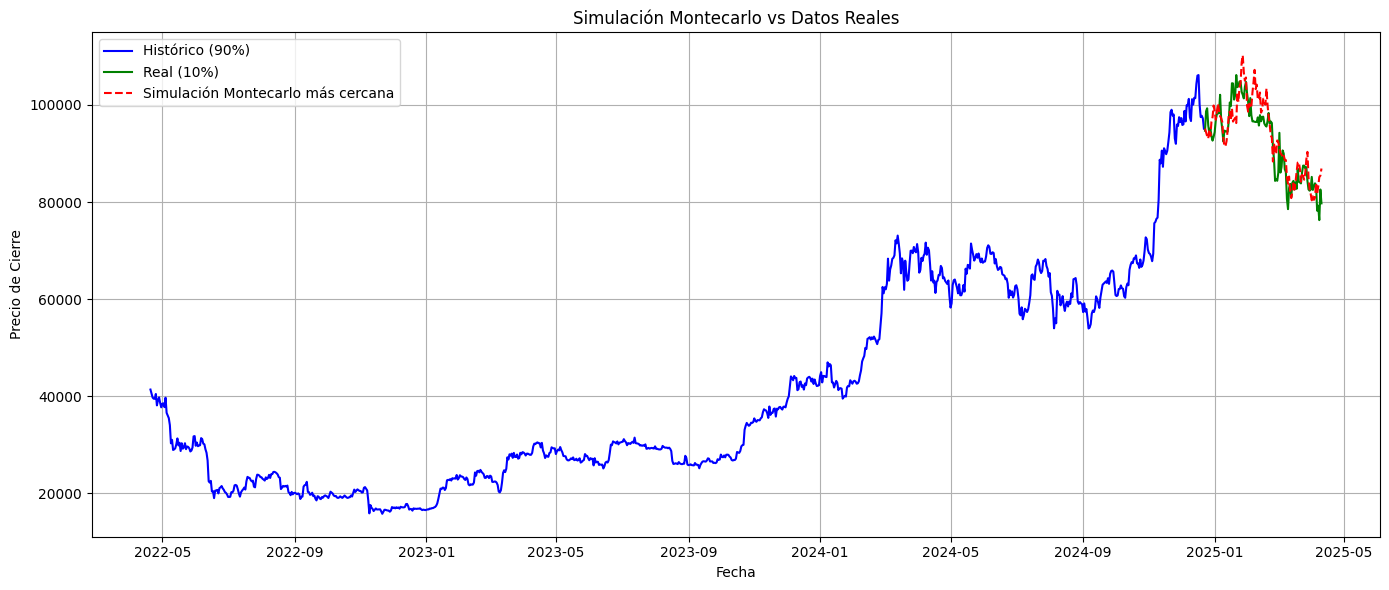

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Leer datos
df = pd.read_csv("/content/btc_USD_historic.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Usamos precio de cierre
prices = df['Close'].values
dates = df['Date'].values

# Separar 90% y 10%
split_idx = int(len(prices) * 0.9)
train_prices = prices[:split_idx]
test_prices = prices[split_idx:]
test_dates = dates[split_idx:]

# Calcular log-retornos sobre el 90%
log_returns = np.log(train_prices[1:] / train_prices[:-1])
mu = log_returns.mean()
sigma = log_returns.std()

# Montecarlo
n_simulations = 20000
n_days = len(test_prices)
last_price = train_prices[-1]

simulations = []
for _ in range(n_simulations):
    prices_sim = [last_price]
    for _ in range(n_days - 1):
        shock = np.random.normal(mu, sigma)
        new_price = prices_sim[-1] * np.exp(shock)
        prices_sim.append(new_price)
    simulations.append(prices_sim)

# Calcular el RMSE con los datos reales ocultos
errors = [np.sqrt(mean_squared_error(test_prices, sim)) for sim in simulations]
best_sim_index = np.argmin(errors)
best_simulation = simulations[best_sim_index]

# Mostrar resultados
plt.figure(figsize=(14, 6))
# Parte real
plt.plot(dates[:split_idx], train_prices, label='Histórico (90%)', color='blue')
# Parte real oculta
plt.plot(test_dates, test_prices, label='Real (10%)', color='green')
# Mejor simulación
plt.plot(test_dates, best_simulation, label='Simulación Montecarlo más cercana', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Simulación Montecarlo vs Datos Reales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

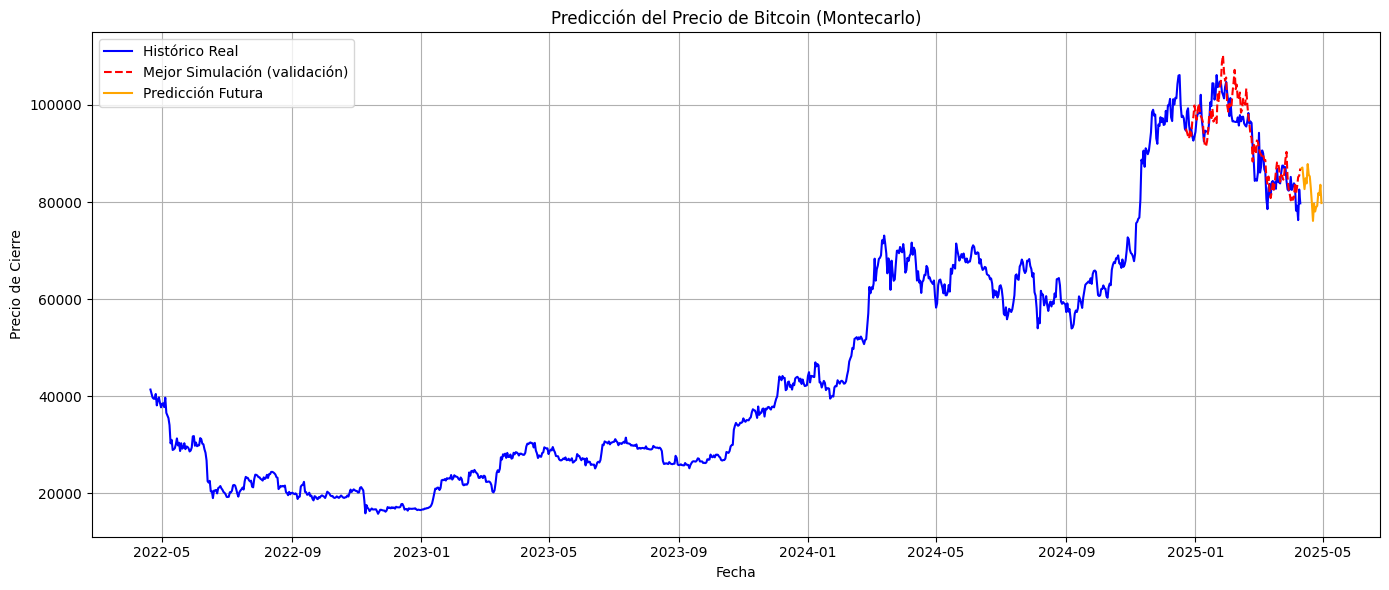

In [ ]:
# Calcular mu y sigma con TODO el histórico
full_log_returns = np.log(prices[1:] / prices[:-1])
mu_full = full_log_returns.mean()
sigma_full = full_log_returns.std()

# Configurar predicción futura
future_days = 20
last_price_pred = best_simulation[-1]

future_prices = [last_price_pred]
for _ in range(future_days - 1):
    shock = np.random.normal(mu_full, sigma_full)
    next_price = future_prices[-1] * np.exp(shock)
    future_prices.append(next_price)

# Crear fechas futuras continuando desde la última fecha
last_date = pd.to_datetime(test_dates[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# Plotear la predicción futura
plt.figure(figsize=(14, 6))
# Parte real completa
plt.plot(dates, prices, label='Histórico Real', color='blue')
# Simulación mejor
plt.plot(test_dates, best_simulation, label='Mejor Simulación (validación)', color='red', linestyle='--')
# Proyección futura
plt.plot(future_dates, future_prices, label='Predicción Futura', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Predicción del Precio de Bitcoin (Montecarlo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


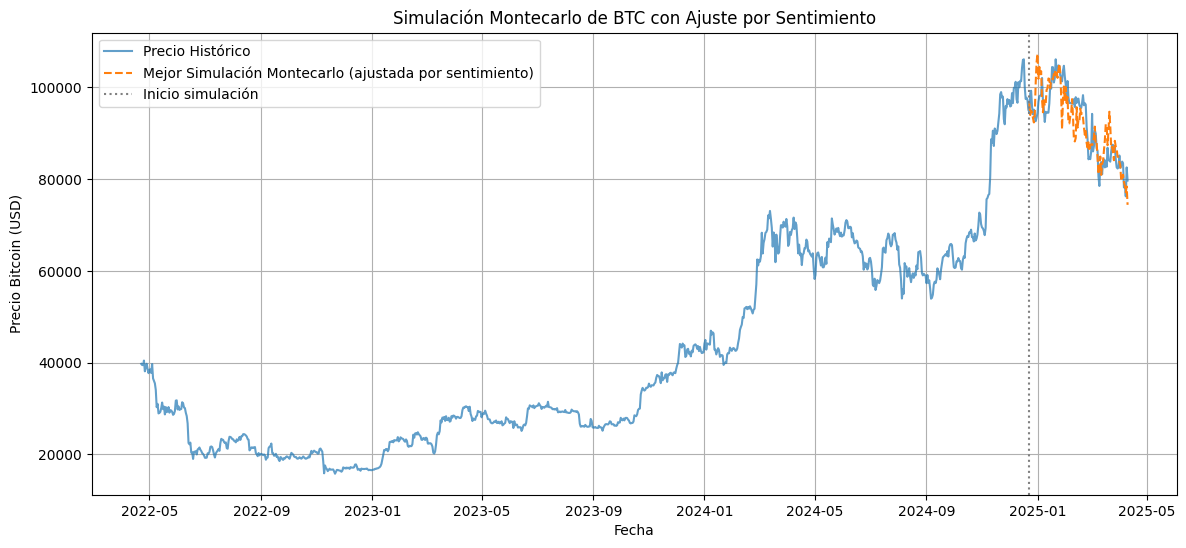

In [ ]:

# === 1. Cargar precios históricos de BTC ===
df_prices = pd.read_csv("/content/btc_USD_historic.csv", parse_dates=["Date"])
df_prices = df_prices.sort_values("Date")

# Calcular retornos logarítmicos
df_prices["Return"] = np.log(df_prices["Close"] / df_prices["Close"].shift(1))
df_prices.dropna(inplace=True)

# === 2. Cargar dataset de sentimiento ===
df_sent = pd.read_csv("/content/noticias_bitcoin_sentimientos.csv", parse_dates=["fecha"])
df_sent = df_sent[["fecha", "score"]]
df_sent.columns = ["Date", "Sentiment"]

# Agrupar sentimiento diario promedio
daily_sentiment = df_sent.groupby('Date')['Sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'SentimentScore']

# === 3. Unir precios y sentimiento ===
df = pd.merge(df_prices, daily_sentiment, how='left', on='Date')
df['SentimentScore'] = df['SentimentScore'].fillna(0)

# Ordenar por fecha
df = df.sort_values('Date')

# === 4. Calcular retornos ajustados por sentimiento ===
alpha = 0.1  # factor de sensibilidad al sentimiento
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
df['AdjReturn'] = df['LogReturn'] + alpha * df['SentimentScore']
df.dropna(inplace=True)

# === 5. Separar 90% de entrenamiento y 10% de prueba ===
cutoff = int(len(df) * 0.9)
train = df.iloc[:cutoff]
test = df.iloc[cutoff:]

# === 6. Simulación Montecarlo usando retornos ajustados ===
n_simulations = 15000
n_days = len(test)

simulations = []
last_price = train['Close'].iloc[-1]
mu = train['AdjReturn'].mean()
sigma = train['AdjReturn'].std()

for _ in range(n_simulations):
    simulated_returns = np.random.normal(mu, sigma, n_days)
    price_path = [last_price]
    for r in simulated_returns:
        price_path.append(price_path[-1] * np.exp(r))
    simulations.append(price_path[1:])  # remover primer precio (redundante)

# === 7. Encontrar la mejor simulación (menor MSE contra datos reales) ===
test_prices = test['Close'].values
errors = [mean_squared_error(test_prices, sim) for sim in simulations]
best_index = np.argmin(errors)
best_simulation = simulations[best_index]

# === 8. Visualización de la simulación ===
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Precio Histórico', alpha=0.7)
plt.plot(test['Date'], best_simulation, label='Mejor Simulación Montecarlo (ajustada por sentimiento)', linestyle='--')
plt.axvline(df['Date'].iloc[cutoff], color='gray', linestyle=':', label='Inicio simulación')
plt.legend()
plt.title('Simulación Montecarlo de BTC con Ajuste por Sentimiento')
plt.xlabel('Fecha')
plt.ylabel('Precio Bitcoin (USD)')
plt.grid(True)
plt.show()


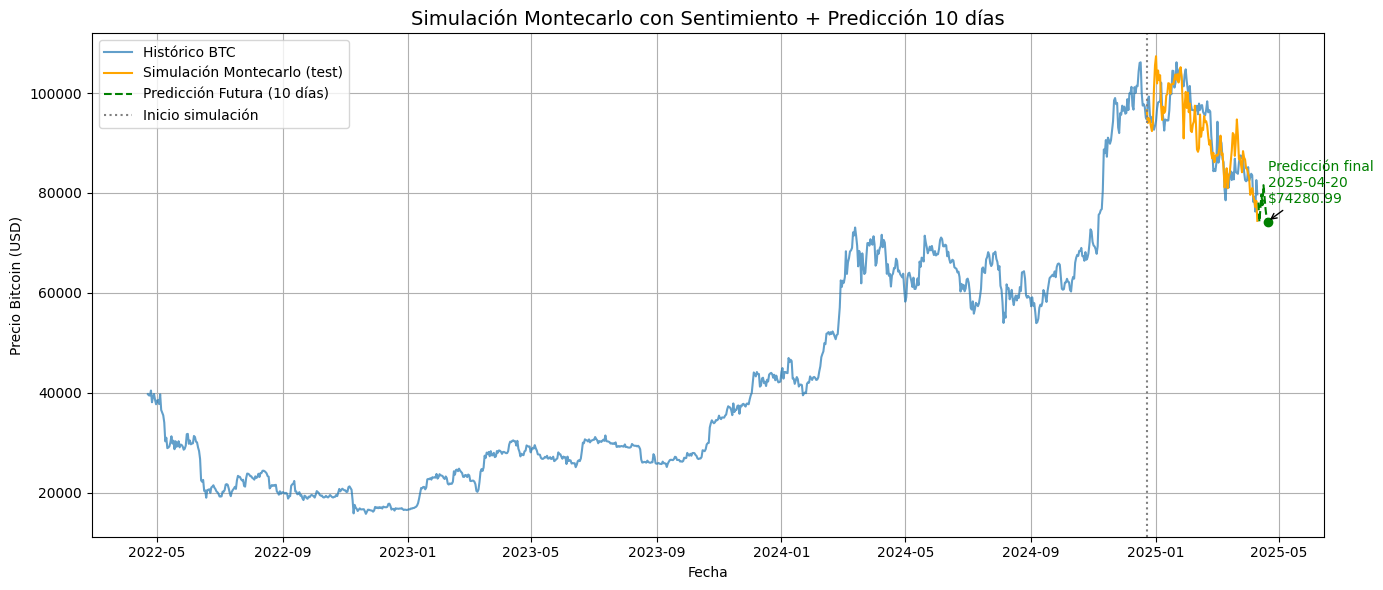

In [ ]:
from datetime import timedelta

# === 1. Parámetros para simulación extendida ===
future_days = 10  # cantidad de días a simular
mu = train['AdjReturn'].mean()
sigma = train['AdjReturn'].std()
last_price_real = df['Close'].iloc[-1]
last_date_real = df['Date'].iloc[-1]

# === 2. Simulación extendida ===
future_simulation = [last_price_real]
for _ in range(future_days):
    r = np.random.normal(mu, sigma)
    next_price = future_simulation[-1] * np.exp(r)
    future_simulation.append(next_price)
future_simulation = future_simulation[1:]  # quitamos el precio inicial duplicado

# Fechas futuras
future_dates = [last_date_real + timedelta(days=i) for i in range(1, future_days + 1)]

# === 3. Visualización incluyendo predicción extendida ===
plt.figure(figsize=(14, 6))

# Histórico y test
plt.plot(df['Date'], df['Close'], label='Histórico BTC', alpha=0.7)
plt.plot(test['Date'], best_simulation, label='Simulación Montecarlo (test)', color='orange')

# Predicción futura extendida
plt.plot(future_dates, future_simulation, label='Predicción Futura (10 días)', color='green', linestyle='--')

# Punto final predicho
final_pred_price = future_simulation[-1]
final_pred_date = future_dates[-1]
plt.scatter(final_pred_date, final_pred_price, color='green')
plt.annotate(f'Predicción final\n{final_pred_date.strftime("%Y-%m-%d")}\n${final_pred_price:.2f}',
             xy=(final_pred_date, final_pred_price),
             xytext=(final_pred_date, final_pred_price * 1.05),
             arrowprops=dict(facecolor='green', arrowstyle="->"),
             fontsize=10,
             color='green')

# Estética
plt.axvline(df['Date'].iloc[cutoff], color='gray', linestyle=':', label='Inicio simulación')
plt.title('Simulación Montecarlo con Sentimiento + Predicción 10 días', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Precio Bitcoin (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()